In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
import json
import numpy as np
import shap
import tensorflow as tf
from random import random
import csv

In [13]:
pid = "port_wine_002"

data = json.load(open(f"./problem_configurations/{pid}/training_results/full_blending_p_nn_xy_lp_75w/regression_data.json"))

mean_reward = np.mean(data["rewards"]) 
print(f"Mean reward: {mean_reward}")

mean_upper_bound_gap = 1- ((mean_reward + 10) / 20)
print(f"Mean upper bound gap: {mean_upper_bound_gap}")


Mean reward: 9.435839014952418
Mean upper bound gap: 0.028208049252379075


[0.62972975, 0.645037894, 0.655947688, 0.668344204, 0.681818882, 0.693546764, 0.706926992, 0.719890758, 0.73108749, 0.742055809, 0.765143204, 0.785300229, 0.804821746, 0.821840649, 0.83640921, 0.851020742, 0.862302423, 0.871807434, 0.880467204, 0.887522028, 0.8937312, 0.901226156, 0.905054982, 0.911849333, 0.916431748, 0.920156798, 0.923872292, 0.926971835, 0.93062436, 0.933242522, 0.934006004, 0.935530779, 0.939115405, 0.939318029, 0.941978577, 0.943749631, 0.945494278, 0.945124336, 0.94559233, 0.947085585, 0.950334995, 0.950604543, 0.951667174, 0.951497583, 0.952062682, 0.951325057, 0.951910466, 0.95342325, 0.953238591, 0.954268499, 0.95328147, 0.953544753, 0.953203923, 0.955710131, 0.955089225, 0.955620197, 0.955238409, 0.955935466, 0.957543658, 0.957524818, 0.959243184, 0.959214234, 0.959529318, 0.957758691, 0.958753881, 0.959960327, 0.959304939, 0.960802212, 0.959861646, 0.960261772, 0.957794638, 0.95788496, 0.959140009, 0.961088772, 0.960638711, 0.959249576, 0.96106653, 0.9602974

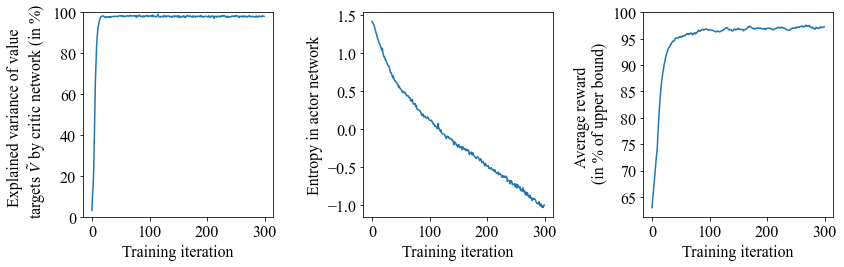

In [123]:
#get training progress from csv file
training_progress = []
with open(f"./problem_configurations/{pid}/average_reward_estimate.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        training_progress.append(row)
average_reward_estimate = [float(x[2]) for x in training_progress[1:301]]
entropy = [float(x[3]) for x in training_progress[1:301]]
vf_explained_variance = [float(x[4]) for x in training_progress[1:301]]
print(average_reward_estimate)



#plot the average reward estimate, the entropy, and the vf explained variance in three subplots
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[2].plot(average_reward_estimate)
ax[2].set_ylabel("Average reward \n (in % of upper bound)")
ax[2].set_xlabel("Training iteration")
ax[2].set_yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],[65, 70, 75, 80, 85, 90, 95, 100])
ax[2].set_xticks([0,100, 200, 300])
ax[1].plot(entropy)
ax[1].set_ylabel("Entropy in actor network")
ax[1].set_xlabel("Training iteration")
ax[1].set_xticks([0,100, 200, 300])
ax[0].plot(vf_explained_variance)
ax[0].set_ylabel("Explained variance of value \n  targets $\\tilde{V}$ by critic network (in %)")
ax[0].set_xlabel("Training iteration")
ax[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],[0, 20, 40, 60, 80, 100])
ax[0].set_xticks([0,100, 200, 300])
ax[0].set_ylim(0, 1)
plt.tight_layout()

plt.savefig(f"./problem_configurations/{pid}/training_progress.pdf")







Average purchasing:  0.5913673812576643
Average production:  {0: 0.18152043325535205, 1: 0.13870640816408802} 0.3202268414194401
Average inventory:  {0: 0.5622569404236265, 1: 0.5314649475215107, 2: 0.5046541303083242, 3: 0.48060533958886775, 4: 0.4583797983334134, 5: 0.437087938779683, 6: 0.41602845335948013, 7: 0.3936292978078429, 8: 0.3664722235352861, 9: 0.32565892065648183, 10: 0.24214879077026039, 11: 0.21265298497939064, 12: 0.19337563422793147, 13: 0.17799411065526352, 14: 0.16455689650114072, 15: 0.1526874654027058, 16: 0.14198902735326283, 17: 0.1319620698429357, 18: 0.12175460547030147, 19: 0.10823004329670151, 20: 0.06278143208625231, 21: 0.044138662842877235, 22: 0.03228449259872145, 23: 0.022632051990059254, 24: 0.012800339513460319}
Average issuance:  {0: 0.004009354822471571, 1: 0.002240261589888971, 2: 0.0012604585302919238, 3: 0.0011624092986500885, 4: 0.0017056765610250386, 5: 0.0029660710413951857, 6: 0.005756092969123621, 7: 0.012106634958225306, 8: 0.0277928507311

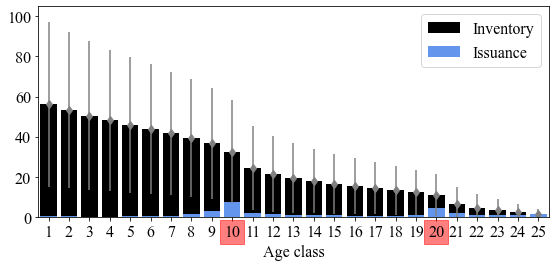

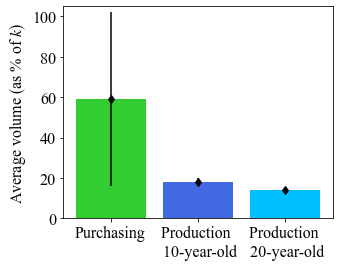

In [122]:
#plot average purchasing, average production, and average inventory
purchasing = np.array([x[0] for x in data["responses"]])/50
production = {i: np.array([x[i+1] for x in data["responses"]])/50 for i in range(2)}
evaporation_remains = {i: 0.98**(i+1) for i in range(25)}

inventory = {i: np.array([x[i+1]*evaporation_remains[i] for x in data["features"]]) for i in range(25)}
issuance = {i: np.array([x[i+3]*evaporation_remains[i] for x in data["responses"]])/50 for i in range(25)}

print("Average purchasing: ", np.mean(purchasing))
print("Average production: ", {i: np.mean(production[i]) for i in range(2)}, sum([np.mean(production[i]) for i in range(2)]))
print("Average inventory: ", {i: np.mean(inventory[i]) for i in range(25)})
print("Average issuance: ", {i: np.mean(issuance[i]) for i in range(25)}, sum([np.mean(issuance[i]) for i in range(25)]))


#plot inventory per age class as bar plot, show std as error bars
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(range(25), [np.mean(inventory[i]) for i in range(25)], color='black')
inventory_std =  [np.std(inventory[i]) for i in range(25)]
print(inventory_std)
#add average issuance as bar with different color
ax.bar(range(25), [np.mean(issuance[i]) for i in range(25)], color='cornflowerblue', alpha=1.0)
ax.errorbar(range(25), [np.mean(inventory[i]) for i in range(25)], [np.std(inventory[i]) for i in range(25)], fmt='d', color='grey')

# ax.set_ylabel("Average volume (as % of $k$)")
ax.set_xlabel("Age class")
ax.set_xticks(range(25), [str(i+1) for i in range(25)])
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.5, 24.5)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0],[0, 20, 40, 60, 80, 100])
#insert legend but not for errorbars
ax.legend(["Inventory", "Issuance"], loc='upper right')

#add a red transparent box around the target ages 10 and 20 and put the text \tau_1 and \tau_2 underneath the box
for i in [9,19]:
    ax.get_xticklabels()[i].set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
    # ax.text(i, -0.2, f"$\\tau_{{{int((i+1)/10)}}}$", ha="center")


plt.tight_layout()
plt.savefig(f"./problem_configurations/{pid}/inventory.pdf")

#plot purchasing and production volumes as bars as well
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
purchasing_and_production = np.array([np.mean(purchasing)] + [np.mean(production[i]) for i in range(2)])
ax.bar(range(3), purchasing_and_production)
ax.errorbar(range(3), purchasing_and_production, np.array([np.std(purchasing)] + [np.std(production[i]) for i in range(2)]), fmt='d', color='black')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0],[0, 20, 40, 60, 80, 100])
ax.set_ylim(0, 1.05)
#set color of first bar to green, second bar to blue, third bar to light blue
ax.patches[0].set_facecolor('limegreen')
ax.patches[1].set_facecolor('royalblue')
ax.patches[2].set_facecolor('deepskyblue')
ax.set_xticks(range(3), ["Purchasing", "Production \n 10-year-old", "Production \n 20-year-old"])
ax.set_ylabel("Average volume (as % of $k$)")

plt.tight_layout()
plt.savefig(f"./problem_configurations/{pid}/purchasing_and_production.pdf")

